# Kaggle Project 
Predict which Tweets are about real disasters and which ones are no


Submitter: Ming Jin

Email: mingjin0616@gmail.com

Date: March 28, 2020

Environment: Python 3.7 

# 1. Import Required Modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('seaborn')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize,sent_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
#from spellchecker import SpellChecker

In [ ]:
import pandas as pd 
import numpy as np 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import sent_tokenize,word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)


# 2.  Read in Datasets

In [3]:
# Read in data
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [4]:
# preview train data
train[train.keyword.notnull()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [5]:
#preview train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
# Count number of rows and columns for all data
print('For train, there are {0} rows and {1} columns.'.format(train.shape[0],train.shape[1]))
print('For test, there are {0} rows and {1} columns.'.format(test.shape[0],test.shape[1]))


For train, there are 7613 rows and 5 columns.
For test, there are 3263 rows and 4 columns.


# 3. Data Preparation

##  keywords and location

### dealing with missing data

In [7]:
print(f'null percent for keyword in train: {round(train.keyword.isnull().sum()*100/len(train),3)}%')
print(f'null percent for keyword in test: {round(test.keyword.isnull().sum()*100/len(test),3)}%')

null percent for keyword in train: 0.801%
null percent for keyword in test: 0.797%


In [8]:
print(f'null percent for location in train: {round(train.location.isnull().sum()*100/len(train),3)}%')
print(f'null percent for location in test: {round(test.location.isnull().sum()*100/len(test),3)}%')

null percent for location in train: 33.272%
null percent for location in test: 33.865%


location has too much null value and is dirty. Besides, do not indicate much information of diseaster, therefore we drop it 

In [9]:
print(train.keyword.nunique())
train.keyword.unique()

221


array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

- notice there exsits '%20' in keyword , use it to split word
- stemming 

In [ ]:
# from nltk.stem.porter import PorterStemmer
# p_stemmer = PorterStemmer()
# X_train = train.drop(columns=['target','location'])
# y_train = train['target']
# X_test = test.drop(columns=['location'])
# for df in [X_test,X_train]:
#     df['keyword'] = df['keyword'].fillna('nokeyword')
#     df['keyword'] = df['keyword'].apply(lambda x:x.split("%20"))
#     df['keyword'] = df['keyword'].apply(lambda row: [p_stemmer.stem(i).lower() for i in row])

## Meta Data

In [ ]:
print(train[train['target']==1].text.head(10))

In [ ]:
print(train[train['target']==0].text.head(10))

In [ ]:
for df in [train,test]:
    df['strip_text'] = df['text'].replace('\n\n', ' ')
    df['strip_text'] = df['strip_text'].replace('\n', ' ')
    df['words'] = df['strip_text'].apply(lambda x: word_tokenize(x))
    df['sentences'] = df['strip_text'].apply(lambda x:sent_tokenize(x))
    df['num_chars'] = df['strip_text'].apply(lambda x:len(x))
    df['num_words'] = df['words'].apply(lambda x:len(x))
    df['num_sentences'] = df['sentences'].apply(lambda x:len(x))
    df['vocab'] = df['words'].apply(lambda x: len({s.lower() for s in x}))
    df['word_size'] = df['num_chars']/df['num_words']
    df['sent_size'] = df['num_words']/df['num_sentences']
    df['num_stop_word'] = df['words'].apply(lambda x: len([w for w in x if w in stopwords.words()]))
    df['num_hash_tag'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
    df['num_mention'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
    df['is_include_url'] = df['words'].apply(lambda x: bool('http' in x)+bool('https' in x)) 

In [ ]:
df_train= X_train.copy()

In [ ]:
cols = ['num_words','num_sentences','word_size','sent_size','num_stop_word','num_hash_tag','num_mention','is_include_url']
    

In [ ]:
# f, axes = plt.subplots(3, 3, figsize=(14, 12))

# for i,col in enumerate(cols): 
#     ax = axes[int(i/3)][i%3]
#     sns.catplot(x='target',y=col,kind='box',data=X_train, ax=ax)

In [ ]:
METAFEATURES = ['num_words','num_sentences','word_size','sent_size','num_stop_word','num_hash_tag','num_mention','is_include_url']
df_train= X_train.copy()
df_test = X_test.copy()
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

### Ngram analysis

In [10]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [11]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

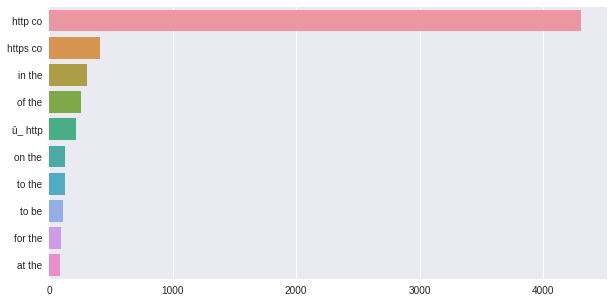

In [12]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(train['text'],10)
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
plt.show()

### words embeding and bov

In [ ]:
# # texts = [[p_stemmer.stem(word).lower() for word in row 
# #         if word not in stopwords.words() and word.isalnum()] 
# #         for row in X_train.words+X_train.keyword]

# # from gensim import corpora
# # dictionary = corpora.Dictionary(texts) #(word_id,word) pairs
# # corpus = [dictionary.doc2bow(text) for text in texts] #(word_id,freq) pairs by sentence

# # for k,v in dictionary.items():
# #     print (k,v)

# from functools import reduce
# total = list(reduce(lambda x, y: x+ y, texts))

# total_corp = dictionary.doc2bow(total)

# #a lot of words only appear once or twice 
# len([x for x in total_corp if x[1]<=2])

# #filter less frequent words
# filter_list = [x[0] for x in total_corp if x[1]>2]
# filtered_corpus = [[x for x in corpu if x[0] in filter_list] for corpu in corpus]
# #translate into dataframe
# bow_df  = pd.DataFrame([dict(i) for i in filtered_corpus])
# X_train = pd.concat([X_train,bow_df],axis=1)

# y_train = X_train.target
# X_train = X_train.drop(columns='target')

# X_train.fillna(0,inplace=True)

# test_texts = [[p_stemmer.stem(word).lower() for word in row 
#         if word not in stopwords.words() and word.isalnum()] 
#         for row in X_test.words+X_test.keyword]
# test_corpus = [dictionary.doc2bow(text) for text in test_texts]
# filtered_test = [[x for x in corpu if x[0] in filter_list] for corpu in test_corpus]
# test_bow_df = pd.DataFrame([dict(i) for i in filtered_test])
# X_test = pd.concat([X_test,test_bow_df],axis=1)


##  Data Cleaning

### remove url

In [13]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [14]:
for df in [train,test]:
    df['text'] = df['text'].apply(lambda x:remove_url(x))

### remove HTML tags

In [15]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

for df in [train,test]:
    df['text'] = df['text'].apply(lambda x:remove_html(x))

### remove Emojis 


In [16]:
 # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [17]:
remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [18]:
for df in [train,test]:
    df['text'] = df['text'].apply(lambda x:remove_emoji(x))

### removing punctuations 

In [19]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [20]:
for df in [train,test]:
    df['text'] = df['text'].apply(lambda x:remove_punct(x))

### removing stopwords

In [23]:
def remove_stopwords(text):
    words = list(filter(lambda x: x not in stop,text))
    #words = [w for w in text if w not in stop]
    return words

In [24]:
for df in [train,test]:
    df['text'] = df['text'].apply(lambda x:remove_stopwords(x))

In [27]:
#combine into str
for df in [train,test]:
    df['text'] = df['text'].apply(lambda x:"".join(x))

### Token normalization 

### Spelling Correction and create corpus 

In [28]:
def create_corpus(df):
    #spell = SpellChecker()
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        #words=[spell.correction(word) if spell.unknown(word) else word for word in words]
        corpus.append(words)
    return corpus

In [29]:
# train_corpus = create_corpus(train)
# test_corpus = create_corpus(test)

100%|██████████| 3263/3263 [00:00<00:00, 4323.63it/s]


### Glove  for Vectorization

In [ ]:
embedding_dict={}
with open('glove.twitter.27B/glove.twitter.27B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(train_corpus)
sequences=tokenizer_obj.texts_to_sequences(train_corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')


In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

### Bag of words

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [49]:
count_vectorizer = CountVectorizer()
#train_text = list(map(lambda x:''.join(x), train_corpus))
#test_text = list(map(lambda x:''.join(x), test_corpus))
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])

## Keeping only non-zero elements to preserve space 
#print(train_vectors[0].todense())

### TFIDF Features 

In [32]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

# 4. Model

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score
#from sklearn.linear_module import LogisticRegression

In [ ]:
# X = X_train.set_index('id').drop(columns =['keyword', 'text',  'strip_text',
#                'words', 'sentences'])
# y = y_train
# X_train, X_dev, y_train, y_dev = \
#         train_test_split(X, y, test_size=.3, random_state=42)


In [50]:
X_train_vec,X_dev_vec, y_train_vec,y_dev_vec = \
train_test_split(train_vectors, train['target'], test_size=.3, random_state=42)

In [36]:
X_train_tf,X_dev_tf, y_train_tf,y_dev_tf = \
train_test_split(train_tfidf, train['target'], test_size=.3, random_state=42)

### Naives Bayes

In [44]:
from sklearn.model_selection import cross_val_score

In [51]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.61654135, 0.59924528, 0.64655172, 0.59480724, 0.72571429])

In [53]:
# Fitting a simple Naive Bayes on tfidf
clf_NB_TFIDF = MultinomialNB()
scores = cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.5257732 , 0.54494903, 0.56233422, 0.51287129, 0.69197584])

## DecisionTree

In [57]:
#counts 
clf_detree = DecisionTreeClassifier()
scores = cross_val_score(clf_detree, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.57117278, 0.46885246, 0.49483013, 0.43911439, 0.57736721])

In [56]:
#tfidf 
clf_detree_tfi = DecisionTreeClassifier()
scores = cross_val_score(clf_detree_tfi, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.56648452, 0.45320197, 0.49802372, 0.46276596, 0.5500382 ])

## Random Forest

In [58]:
#counts 
clf_RF = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf_RF, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.47588424, 0.43314501, 0.47079038, 0.46122449, 0.58028169])

In [59]:
#tfidf
clf_RF_tfidf = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf_RF_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.49460043, 0.38955823, 0.44340505, 0.40473628, 0.61141805])

### XGBoost

In [61]:
import xgboost as xgb 
#counts 
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.50780437, 0.41242938, 0.50635055, 0.43157895, 0.62206148])

In [62]:
#tfidf
clf_xgb_tfidf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = cross_val_score(clf_xgb_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.52695829, 0.43129771, 0.48596491, 0.44785276, 0.61961503])

### FIT NB and submit result 

In [67]:
clf = MultinomialNB()
clf.fit(train_vectors,train['target'])
y_pred = clf.predict(test_vectors)

In [68]:
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [ ]:
submission['target']= y_pred
submission.to_csv('submission.csv',index=False)